# 5 - Results
In this notebook, we will create plots for all the conditions and RNAs in our dataset. Some of these figure were also used in the publication linked to this dataset. 

## 5.1 - Load data

In [15]:
import sys
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator
import logging
import seaborn as sns

In [23]:
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s ', datefmt='%m/%d/%Y %I:%M:%S%p', level=logging.INFO)
rootdir = "../tests/output"
logging.info(f'reading from directory {rootdir}')

dfs = []
for f in list(Path(rootdir).glob('*/*results.csv')):
    logging.info(f'..loading file: {f}')
    df = pd.read_csv(f)
    dfs.append(df)
df = pd.concat(dfs).reset_index()

09/26/2024 12:00:26PM [INFO] reading from directory ../tests/output 
09/26/2024 12:00:26PM [INFO] ..loading file: ../tests/output/MG1655_LB_01/MG1655_LB_01_rnlAB_results.csv 
09/26/2024 12:00:26PM [INFO] ..loading file: ../tests/output/MG1655_LB_01/MG1655_LB_01_rpoD_results.csv 
09/26/2024 12:00:26PM [INFO] ..loading file: ../tests/output/MG1655_LB_01/MG1655_LB_01_hipBA_results.csv 
09/26/2024 12:00:26PM [INFO] ..loading file: ../tests/output/Ecoli_GLY_01/Ecoli_GLY_01_hipBA_results.csv 
09/26/2024 12:00:26PM [INFO] ..loading file: ../tests/output/Ecoli_GLY_01/Ecoli_GLY_01_rnlAB_results.csv 
09/26/2024 12:00:26PM [INFO] ..loading file: ../tests/output/Ecoli_GLY_01/Ecoli_GLY_01_rpoD_results.csv 
09/26/2024 12:00:26PM [INFO] ..loading file: ../tests/output/Ecoli_GLU_05/Ecoli_GLU_05_rnlAB_results.csv 
09/26/2024 12:00:26PM [INFO] ..loading file: ../tests/output/Ecoli_GLU_05/Ecoli_GLU_05_hipBA_results.csv 
09/26/2024 12:00:26PM [INFO] ..loading file: ../tests/output/Ecoli_GLU_05/Ecoli_GLU_0

In [24]:
df

,index,Unnamed: 0,label,bbox-0,bbox-1,bbox-2,bbox-3,area,eccentricity,spots_per_cell,dense_regions_per_cell,decomposed_RNAs,tx_per_cell,nascent_RNAs,nuclei,total_RNAs_per_cell,strain,condition,seqnr,mRNA
0,0,0,1,0,883,19,894,115.0,0.941058,0,0,0,0,0,0,0,MG1655,LB,1,rnlAB
1,1,1,2,0,1167,8,1174,46.0,0.540315,0,0,0,0,0,1,0,MG1655,LB,1,rnlAB
2,2,2,3,0,1297,5,1303,20.0,0.567587,0,0,0,0,0,0,0,MG1655,LB,1,rnlAB
3,3,3,4,0,1392,6,1398,30.0,0.671317,0,0,0,0,0,0,0,MG1655,LB,1,rnlAB
4,4,4,5,0,1513,2,1520,13.0,0.965209,0,0,0,0,0,0,0,MG1655,LB,1,rnlAB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17962,2283,2283,2284,2300,1393,2304,1412,66.0,0.978212,0,0,0,0,0,0,0,Ecoli,GLU,2,hipBA
17963,2284,2284,2285,2300,2210,2304,2228,57.0,0.979484,0,0,0,0,0,0,0,Ecoli,GLU,2,hipBA
17964,2285,2285,2286,2301,2100,2304,2110,20.0,0.975725,0,0,0,0,0,0,0,Ecoli,GLU,2,hipBA
17965,2286,2286,2287,2301,2111,2304,2120,24.0,0.941380,0,0,0,0,0,0,0,Ecoli,GLU,2,hipBA


In [25]:
# inspect data
df.columns

Index(['index', 'Unnamed: 0', 'label', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3',
       'area', 'eccentricity', 'spots_per_cell', 'dense_regions_per_cell',
       'decomposed_RNAs', 'tx_per_cell', 'nascent_RNAs', 'nuclei',
       'total_RNAs_per_cell', 'strain', 'condition', 'seqnr', 'mRNA'],
      dtype='object')

In [26]:
# store variables:

mRNAs = df['mRNA'].unique()
conditions = df['condition'].unique()
mRNAs, conditions

(array(['rnlAB', 'rpoD', 'hipBA'], dtype=object),
 array(['LB', 'GLY', 'GLU'], dtype=object))

## 5.1 - Histograms of mRNA counts and eccentricity

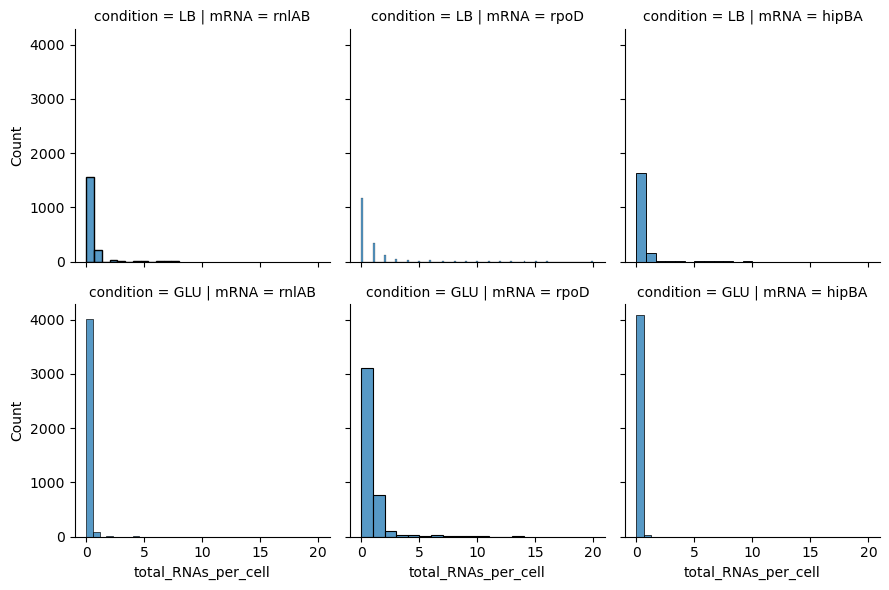

In [89]:
g = sns.FacetGrid(df.query('condition != "GLY"'), col='mRNA', row='condition')
g.map_dataframe(sns.histplot, x='total_RNAs_per_cell');

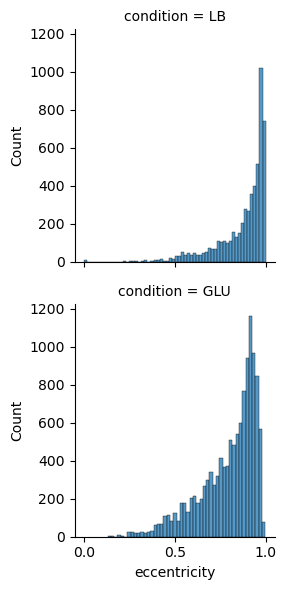

In [91]:
g = sns.FacetGrid(df.query('condition != "GLY"'), row='condition')
g.map_dataframe(sns.histplot, x='eccentricity');

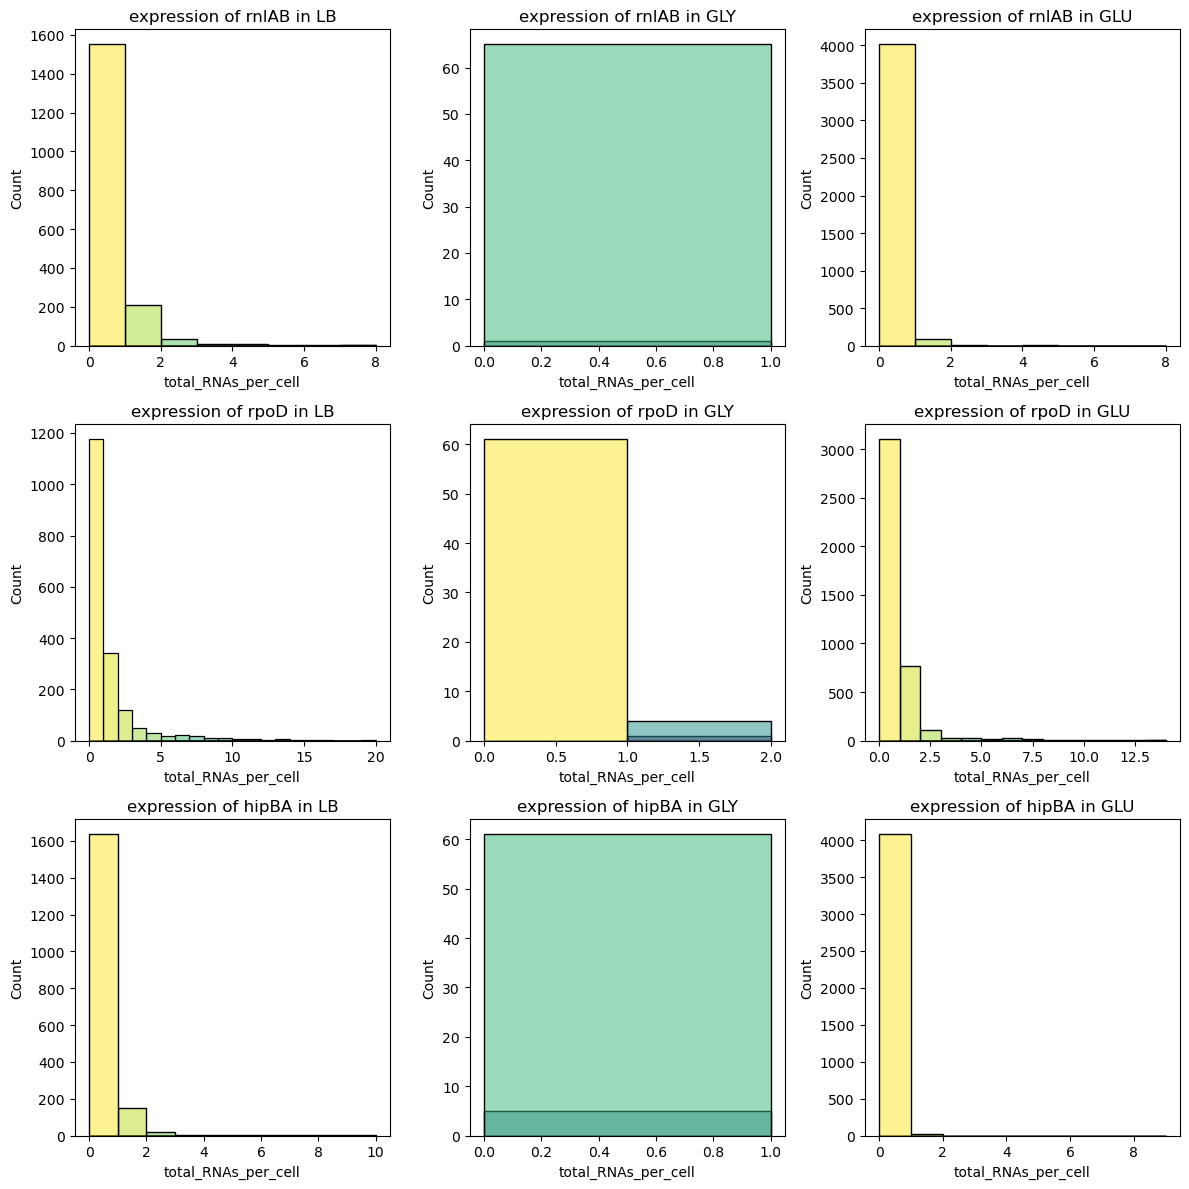

In [76]:
nrows = len(mRNAs)
ncols = len(conditions)

figure, axes= plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12))
axes = np.array(axes).reshape(nrows, ncols)

for row, mRNA in enumerate(mRNAs):
    for col, condition in enumerate(conditions):
        
        sns.histplot(
            data=df[(df['mRNA']==mRNA) & (df['condition']==condition)], 
            x='total_RNAs_per_cell',
            ax=axes[row, col],binwidth=1, 
            hue='total_RNAs_per_cell',
            palette='viridis_r', legend=False)
        
        # axes[row,col].set_xlim(0,90)
        # axes[row,col].set_ylim(0,80)
        
        axes[row,col].set_title(f'expression of {mRNA} in {condition}')
        
plt.tight_layout()

***

## 5.2 - Scatterplots mRNA vs eccentricity (with marginal KDEs and Histplots)

In [79]:
mRNA = 'rnlAB'
condition = 'GLU'
df[(df['mRNA']==mRNA) & (df['condition']==condition)]

,index,Unnamed: 0,label,bbox-0,bbox-1,bbox-2,bbox-3,area,eccentricity,spots_per_cell,dense_regions_per_cell,decomposed_RNAs,tx_per_cell,nascent_RNAs,nuclei,total_RNAs_per_cell,strain,condition,seqnr,mRNA
5655,0,0,1,0,411,13,426,97.0,0.906240,0,0,0,0,0,0,0,Ecoli,GLU,5,rnlAB
5656,1,1,2,0,441,5,446,17.0,0.835865,0,0,0,0,0,0,0,Ecoli,GLU,5,rnlAB
5657,2,2,3,0,1080,3,1089,16.0,0.969374,0,0,0,0,0,0,0,Ecoli,GLU,5,rnlAB
5658,3,3,4,0,1777,3,1797,43.0,0.992847,0,0,0,0,0,0,0,Ecoli,GLU,5,rnlAB
5659,4,4,5,0,1857,12,1873,83.0,0.945875,0,0,0,0,0,1,0,Ecoli,GLU,5,rnlAB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13386,2283,2283,2284,2300,1393,2304,1412,66.0,0.978212,0,0,0,0,0,0,0,Ecoli,GLU,2,rnlAB
13387,2284,2284,2285,2300,2210,2304,2228,57.0,0.979484,0,0,0,0,0,0,0,Ecoli,GLU,2,rnlAB
13388,2285,2285,2286,2301,2100,2304,2110,20.0,0.975725,0,0,0,0,0,0,0,Ecoli,GLU,2,rnlAB
13389,2286,2286,2287,2301,2111,2304,2120,24.0,0.941380,0,0,0,0,0,0,0,Ecoli,GLU,2,rnlAB


In [80]:
df.columns

Index(['index', 'Unnamed: 0', 'label', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3',
       'area', 'eccentricity', 'spots_per_cell', 'dense_regions_per_cell',
       'decomposed_RNAs', 'tx_per_cell', 'nascent_RNAs', 'nuclei',
       'total_RNAs_per_cell', 'strain', 'condition', 'seqnr', 'mRNA'],
      dtype='object')

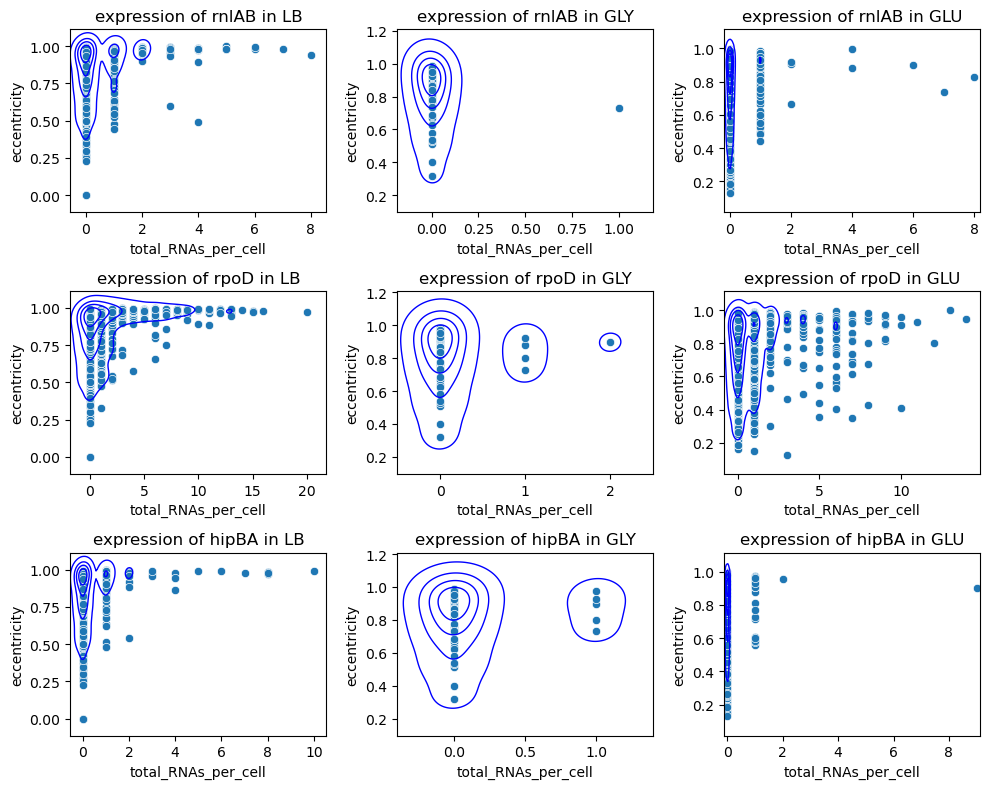

In [85]:
nrows = len(mRNAs)
ncols = len(conditions)

figure, axes= plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,8))
axes = np.array(axes).reshape(nrows, ncols)

for row, mRNA in enumerate(mRNAs):
    for col, condition in enumerate(conditions):
        sns.scatterplot(data=df[(df['mRNA']==mRNA) & (df['condition']==condition)], 
                        x='total_RNAs_per_cell',
                        y='eccentricity',
                        ax=axes[row,col])
        sns.kdeplot(data=df[(df['mRNA']==mRNA) & (df['condition']==condition)],
                    x='total_RNAs_per_cell',y='eccentricity', 
                    levels=5, color="b", linewidths=1, ax=axes[row, col])
#         axes[row,col].set_xlim(0,80)
#         axes[row,col].set_ylim(0,1)
        
        axes[row,col].set_title(f'expression of {mRNA} in {condition}')
        
#plt.savefig(f'scatter_kdeplot_{mRNA}_{condition}.svg')

plt.tight_layout()

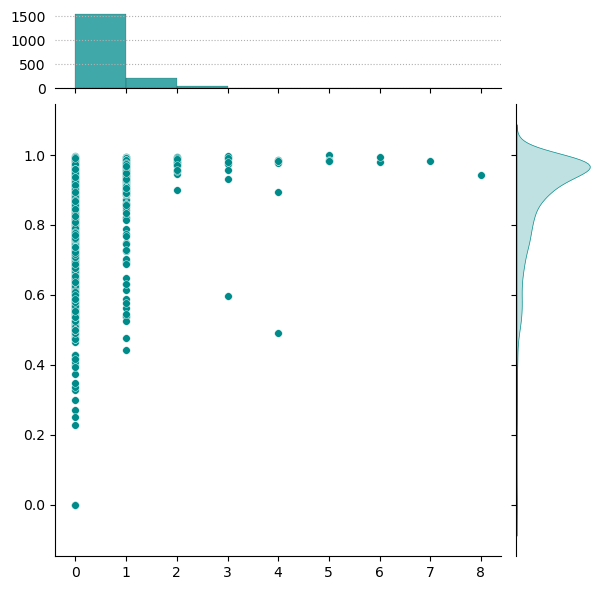

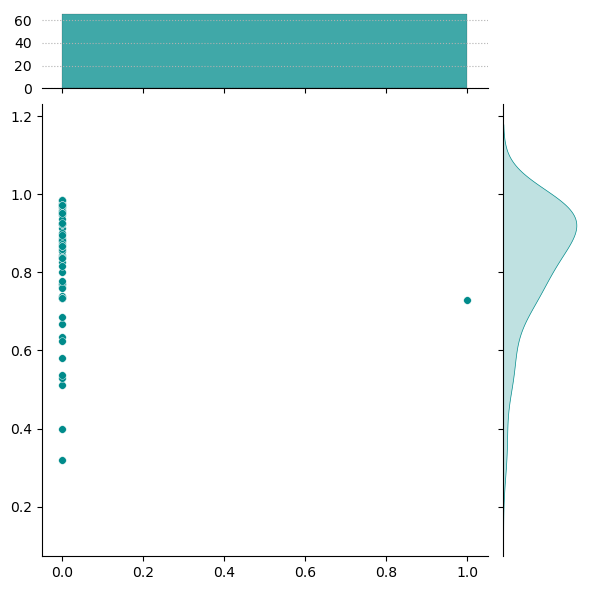

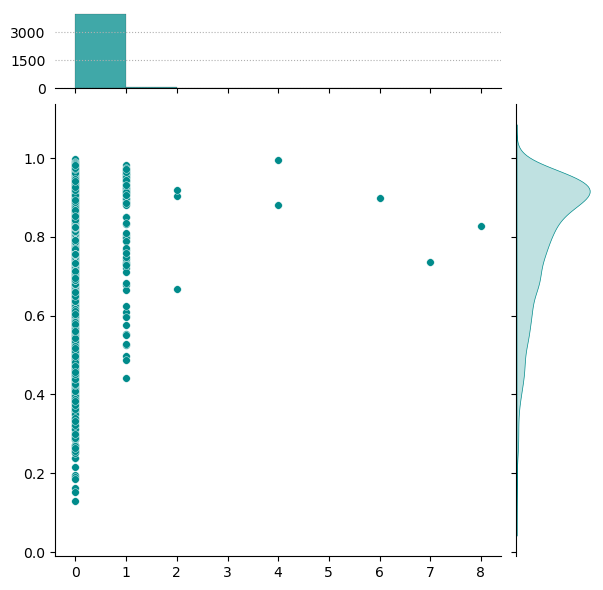

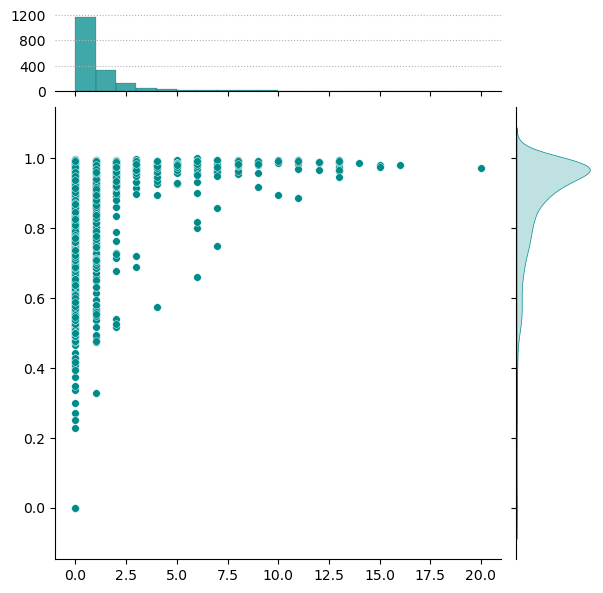

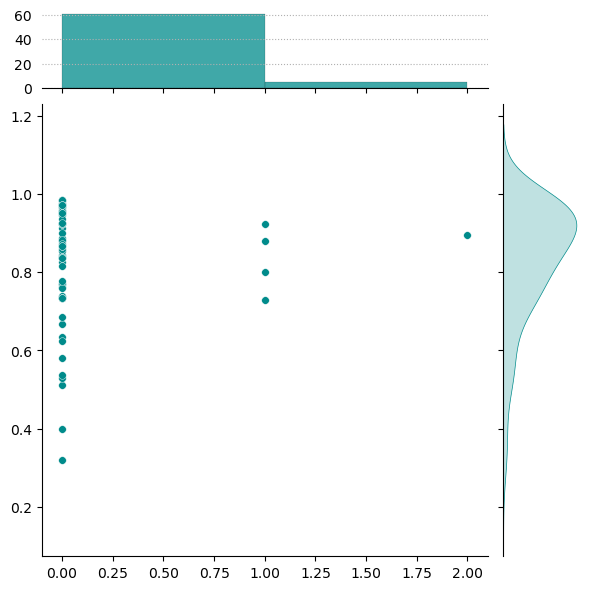

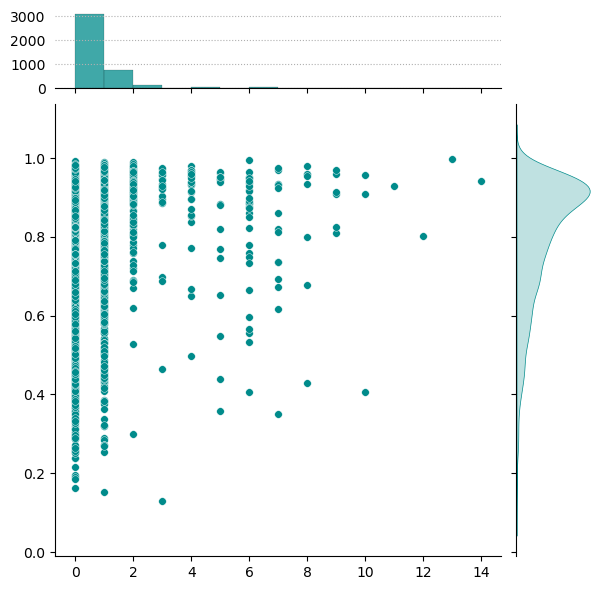

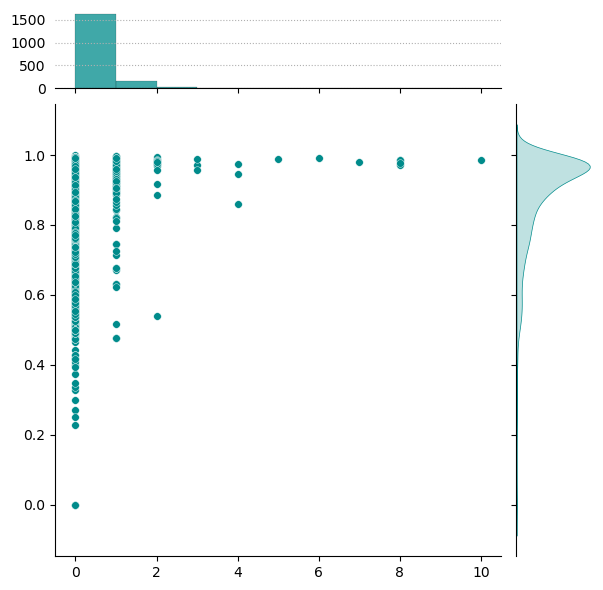

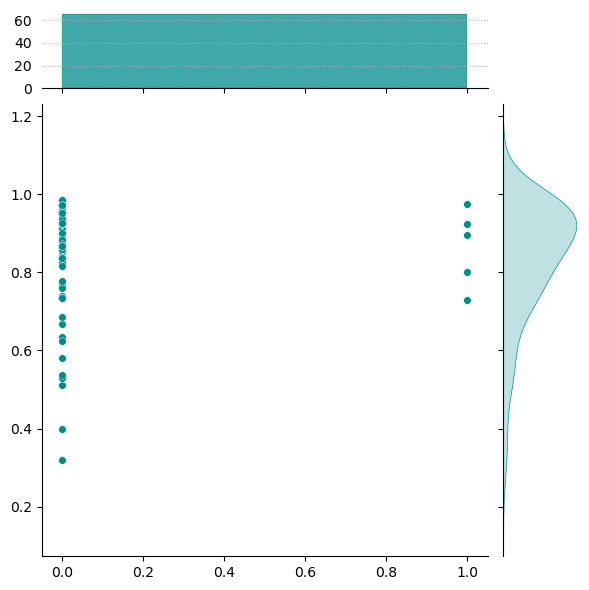

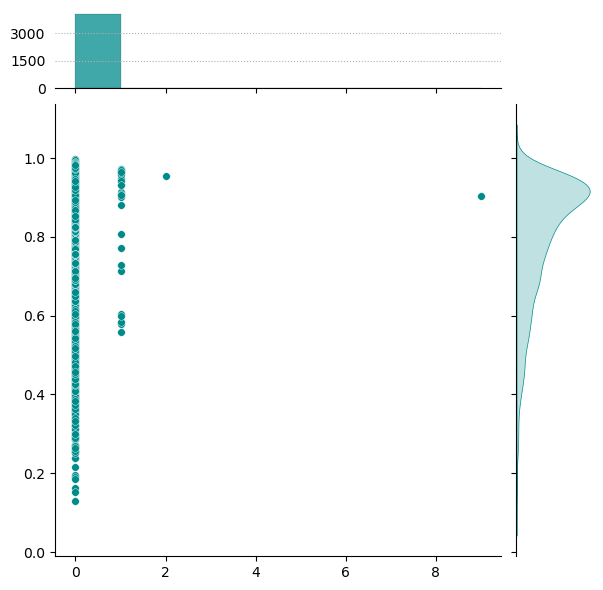

In [87]:
# adjust plotting settings
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

nrows = len(mRNAs)
ncols = len(conditions)

axes = np.array(axes).reshape(nrows, ncols)
for row, mRNA in enumerate(mRNAs):
    for col, condition in enumerate(conditions):
        
        selected_data = df[(df['mRNA']==mRNA) & (df['condition']==condition)]

        g = sns.JointGrid()
        x, y = selected_data["total_RNAs_per_cell"], selected_data["eccentricity"]
        sns.scatterplot(x=x, y=y, ec='white', c="darkcyan", s=30, linewidth=.3, ax=g.ax_joint)
        sns.histplot(x=x, binwidth= 1, linewidth=0.1, ax=g.ax_marg_x, color="darkcyan")
        sns.kdeplot(y=y, linewidth=0.5, ax=g.ax_marg_y, fill=True, color="darkcyan")
        # g.ax_joint.set_xlim(-5,90)
        
        g.ax_marg_x.tick_params(labelleft=True,labelsize= 10)
        g.ax_marg_x.grid(True, axis='y', ls=':')
        g.ax_marg_x.yaxis.set_major_locator(MaxNLocator(4))
        g.ax_joint.set_xlabel('')
        g.ax_joint.set_ylabel('')
        
        #plt.savefig(f'fv_jointplot_{mRNA}_{condition}.svg')

***

## 5.3 - Stripplots

In [ ]:
ax = sns.stripplot(
    data=df,
    x="mRNA", 
    y="spots per cell", 
    orient="v",palette='viridis' ,hue='condition',dodge=True, s=3, alpha=0.3)

ax.set_title('spots per cell')
ax.set_ylim(0,85)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#plt.savefig('stripplot_spot_per_cell.svg')

### <span style="color:seagreen"> 5.3.1 - Plotting only expressing cells </span>

In [ ]:
ax=sns.stripplot(
    data=df[df['total RNAs per cell']>0],
    x="condition", y="total RNAs per cell", orient="v",palette='viridis' ,hue='mRNA',dodge=True, s=3, alpha=0.5
)
ax.set_title('RNAs_per_cell')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(0,85)

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="condition",
            y="total RNAs per cell",
            hue='mRNA',
            data=df[df['total RNAs per cell']>0],
            showfliers=False,
            showbox=False,
            showcaps=False)
plt.legend(title='mRNA', loc='upper right', labels=['CLB2Q670', 'EFG1Q670'],markerscale=5)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#plt.savefig('FV_stripplot_total_RNAs.svg')

### <span style="color:seagreen"> 5.3.2 - Plotting nascent mRNA per cell </span>

In [ ]:
ax=sns.stripplot(
    data=df[df['nascent RNAs']>0],
    x="condition", y="nascent RNAs", orient="v",palette='viridis' ,hue='mRNA',dodge=True, s=3, alpha=0.5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_title('nascent RNAs per cell')
ax.set_ylim(0,35)

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="condition",
            y="nascent RNAs",
            hue='mRNA',
            data=df[df['nascent RNAs']>0],
            showfliers=False,
            showbox=False,
            showcaps=False)
plt.legend(title='mRNA', loc='upper right', labels=['CLB2Q670', 'EFG1Q670'],markerscale=5)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#plt.savefig('FV_nascent_stripplot.svg')